In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import h5py
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import normalize
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 10
num_classes = 1
epochs = 50
channels = 2

In [3]:
#image input dimensions
img_x, img_y = 75,75

In [4]:
#load train  data
train = pd.read_json('./TrainData/data/processed/train.json')
bands = ['band_1','band_2']
x_total = np.empty([1604,0])
for band in bands:
    x_temp = np.zeros((1604,5625))
    for x in range(1604):
        x_temp[x] += train[band][x]
    #x_temp = keras.utils.normalize(x_temp)
    x_total = np.concatenate((x_total,x_temp),axis=1)
y_total = np.array(train['is_iceberg']) 
y_total = y_total.reshape(1604,1)
x_train = x_total
y_train = y_total

In [5]:
#Splitting into test data
#x_train, x_test =x_total[:1444,:], x_total[1444:,:]
#y_train, y_test =y_total[:1444,:], y_total[1444:,:]

In [6]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# two channels
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, channels)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, channels)
input_shape = (img_x, img_y, channels)

In [13]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2)))
model.add(Dropout(0.2))
          
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

             
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
          
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
          
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='sigmoid'))
opt = keras.optimizers.Adam()

history = keras.callbacks.History()

In [14]:
def getBestModel():
    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
    model.summary()
    best_weights_filepath = './best_weights.hdf5'
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='auto')
    saveBestModel = keras.callbacks.ModelCheckpoint(best_weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train model
    history = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=epochs,
              verbose=1, validation_split= 0.10, callbacks=[earlyStopping, saveBestModel])

    #reload best weights
    model.load_weights(best_weights_filepath)
    return model, history

In [15]:
model,history = getBestModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 64)        1216      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

/home/angel/tensorflow/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1443 samples, validate on 161 samples
Epoch 1/50
1443/1443 [==============================] - 22s 15ms/step - loss: 0.7286 - acc: 0.6286 - val_loss: 0.6005 - val_acc: 0.4410
Epoch 2/50
1443/1443 [==============================] - 23s 16ms/step - loss: 0.5591 - acc: 0.6979 - val_loss: 0.6260 - val_acc: 0.4286
Epoch 3/50
1443/1443 [==============================] - 21s 15ms/step - loss: 0.5360 - acc: 0.7138 - val_loss: 0.6618 - val_acc: 0.4286
Epoch 4/50
1443/1443 [==============================] - 23s 16ms/step - loss: 0.5159 - acc: 0.7277 - val_loss: 0.7800 - val_acc: 0.5217
Epoch 5/50
1443/1443 [==============================] - 23s 16ms/step - loss: 0.5181 - acc: 0.7394 - val_loss: 0.6886 - val_acc: 0.4783
Epoch 6/50
1443/1443 [==============================] - 22s 15ms/step - loss: 0.4962 - acc: 0.7512 - val_loss: 0.4796 - val_acc: 0.7578
Epoch 7/50
1443/1443 [==============================] - 23s 16ms/step - loss: 0.4739 - acc: 0.7609 - val_loss: 0.5727 - val_acc: 0.5528
E

Epoch 32/50
1443/1443 [==============================] - 21s 15ms/step - loss: 0.2290 - acc: 0.8884 - val_loss: 0.3285 - val_acc: 0.8758
Epoch 33/50
1443/1443 [==============================] - 22s 15ms/step - loss: 0.2254 - acc: 0.9064 - val_loss: 0.3064 - val_acc: 0.9068
Epoch 34/50
1443/1443 [==============================] - 21s 15ms/step - loss: 0.2565 - acc: 0.8891 - val_loss: 0.4139 - val_acc: 0.7640
Epoch 35/50
1443/1443 [==============================] - 21s 15ms/step - loss: 0.2391 - acc: 0.9037 - val_loss: 0.4652 - val_acc: 0.8075
Epoch 36/50
1443/1443 [==============================] - 22s 16ms/step - loss: 0.2341 - acc: 0.8891 - val_loss: 0.3221 - val_acc: 0.8137
Epoch 37/50
1443/1443 [==============================] - 21s 15ms/step - loss: 0.2402 - acc: 0.8877 - val_loss: 0.4478 - val_acc: 0.7826
Epoch 38/50
1443/1443 [==============================] - 22s 16ms/step - loss: 0.2264 - acc: 0.8954 - val_loss: 0.2950 - val_acc: 0.8820
Epoch 39/50
1443/1443 [==================

Test loss: 0.170318229983
Test accuracy: 0.922693266833


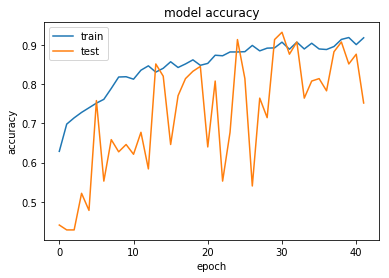

In [16]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

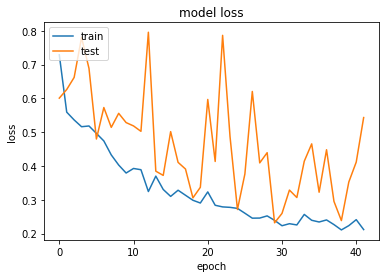

0.465165753322


In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
hist = history.history['val_loss']
print(sum(hist)/len(hist))

In [18]:
test = pd.read_json('./TestData/processed/test.json')

In [19]:
bands = ['band_1','band_2']
x_test = np.empty([8424,0])
for band in bands:
    x_temp = np.zeros((8424,5625))
    for x in range(8424):
        x_temp[x] += test[band][x]
    x_test = np.concatenate((x_test,x_temp),axis=1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, channels)    

In [20]:
predictions = model.predict(x_test)

In [21]:
#Setting ids as PassengerId and predicting survival
ids = test['id']

df1 = pd.DataFrame(predictions)
df2 = pd.DataFrame(ids)
result = pd.concat([df1, df2], axis=1, join_axes=[df1.index])
result.columns = ['is_iceberg', 'id']
result=result.reindex(columns=['id','is_iceberg'])
result.to_csv('8thSubmission.csv', index=False)

In [22]:
np.unique(predictions)

array([  0.00000000e+00,   1.56889937e-38,   1.92293042e-38, ...,
         9.99999762e-01,   9.99999881e-01,   1.00000000e+00], dtype=float32)